# GPT: Zara Smart Naming

**By:** Camila Barbagallo, Ryan Daher, Rocío González Lantero, Joaquin Maroto

**Resources**
https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=gFsCTp_mporB

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Training Set

In [ ]:
# load into a data frame
df = pd.read_csv('Cleaned_train.csv')  
print(df)

       Unnamed: 0  ...                                description_cleaned
0               0  ...  jacket technical fabric texture high collar lo...
1               1  ...  oversized long sleeve shirt round collar featu...
2               2  ...  high waist trouser matching elastic waistband ...
3               3  ...  collared dress feature sleeve fall elbow cuff ...
4               4  ...  loose fitting midi dress round neckline short ...
...           ...  ...                                                ...
33608       33608  ...            beige blanket check design fringing end
33609       33609  ...                                 small wooden stool
33610       33610  ...  kilim style rug wool polyamide multicoloure st...
33611       33611  ...             wooden bench handle weave paper detail
33612       33612  ...                      vintage effect rug brown tone

[33613 rows x 3 columns]


In [ ]:
df.columns

Index(['Unnamed: 0', 'name', 'description_cleaned'], dtype='object')

In [ ]:
df.dropna(inplace=True) #remove NA values
df.reset_index(inplace=True)

In [ ]:
df, df_validation = train_test_split(df,test_size=0.1)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
descrs = df.description_cleaned.copy() #just use the main bio text in this example
names= df.name.copy()

## GPT2-Tokenizer

In [ ]:
# Load the GPT tokenizer and declare tokens
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', unk_token= '[UNK]',sep_token= '<|sep|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## PyTorch Datasets and Dataloaders

In [ ]:
# creating Dataset class
batch_size = 2
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, names, tokenizer, gpt2_type="gpt2", max_length=768 ):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for i in range(len(txt_list)):

      encodings_dict = tokenizer('<|startoftext|>'+ txt_list[i] +'<|sep|>'+ names[i] +'<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(descrs, names, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

27,225 training samples
3,025 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Fine-tune GPT2 Language Model

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 1 # we could only run 1 epoch due to computing power
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  output_dir = './model_save/'+str(epoch_i)

  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  15,125. Loss: 2.031334400177002.   Elapsed: 0:00:53.
0:  bipartisan


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  15,125. Loss: 0.414937287569046.   Elapsed: 0:01:53.
0:  increasing b button pocket button metal line c. thread neck. b feature t feature- t S- metaled cut fast match print. dress pocket leather short waist short model- line long- short pocket - long long fabric. leather leather b long card- patch t patch pocketS long j


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  15,125. Loss: 0.19651134312152863.   Elapsed: 0:02:51.
0: day TR height cm pocket pocket round


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  15,125. Loss: 0.19501535594463348.   Elapsed: 0:03:49.
0:  Hang6 button neck metal WITH neck printline detailline fabric.. pocket long


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  15,125. Loss: 0.8932749032974243.   Elapsed: 0:04:47.
0:  foods WITH shirt 69 cm detail long feature pocket fast contrast fastening


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  15,125. Loss: 0.5473133325576782.   Elapsed: 0:05:45.
0:  trail waist sleeve modellineIRT WITH zip sleeve


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  15,125. Loss: 0.3459444046020508.   Elapsed: 0:06:42.
0: intendED fast TRINT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  15,125. Loss: 0.24060574173927307.   Elapsed: 0:07:40.
0:  surround cm neck hem detail detaillineIRT long fast


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  15,125. Loss: 0.383348673582077.   Elapsed: 0:08:38.
0:  reflex waist fast short waist strap- 69 trim print 177 WITHEDED


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  15,125. Loss: 0.18816730380058289.   Elapsed: 0:09:36.
0:  display sleeve elastic fast metal flap pocket adjustable pocket height contrast neck zip trim contrast round fast fast trimening height feature sleeve featureening elastic fast snap neck button trim neck strap strap belt sleeve adjustable model pocket button fly fast leather print- zip 1776 fast 177 model


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  15,125. Loss: 0.20327889919281006.   Elapsed: 0:10:34.
0:  pastor sleeve dress long sleeve.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  15,125. Loss: 0.17251746356487274.   Elapsed: 0:11:31.
0:  illicitser height long sleeve shirt 177.EDED WITH


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  15,125. Loss: 0.18729440867900848.   Elapsed: 0:12:29.
0:  Liberation cmt cotton design blend height height adjustable detail feature adjustable fast feature button snap elastic fasteningOUS-ITIC WITH BLINQUOTE PORTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  15,125. Loss: 0.14463353157043457.   Elapsed: 0:13:27.
0:  Namtcade tuffle pocket effect print print metalED RUUX TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  15,125. Loss: 0.15672802925109863.   Elapsed: 0:14:25.
0: IONjean shoulder round necklineWITCH


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  15,125. Loss: 0.28829026222229004.   Elapsed: 0:15:23.
0:  glimpseshort sleeve patch pocket five zip fastening print print designDENIM-ZIPPED BLAZER T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  15,125. Loss: 0.23618671298027039.   Elapsed: 0:16:21.
0:  Laureblack regular leather leather feature long sleeve fastening height model 177 cm 69.6TEXTURED TOP


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  15,125. Loss: 0.14531739056110382.   Elapsed: 0:17:18.
0: ismsara jean polo ruffle trim height model 177 cm 69.6FLEATHER WITH REVERSIBLE CROSSBODYSUIT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  15,125. Loss: 0.0731164738535881.   Elapsed: 0:18:16.
0: ounlong sleeve round neckline wide hem adjustable drawstring trim invisible zip closure height model 177 cm 69.6Zara SKIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  15,125. Loss: 0.07743028551340103.   Elapsed: 0:19:14.
0:  electionbermudauda straight leg sleeve elastic cuff button trim hemPRINT RIBBED DENIM JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  15,125. Loss: 0.09506198018789291.   Elapsed: 0:20:12.
0:  crazyknit round neckline short sleeve feature elastic waistbandPLEATED JACKET TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  15,125. Loss: 0.07287579029798508.   Elapsed: 0:21:09.
0:  bencht shirt wide leg pocket fray hem invisible zip fastening height model 177 cm 69.6QUINNED SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  15,125. Loss: 0.1260751336812973.   Elapsed: 0:22:07.
0:  incorporatedcollared high neck sweater feature elastic waistband height model 177 cm 69.6KNIT SWEATER WITH FAUX SUEDE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  15,125. Loss: 0.05845861881971359.   Elapsed: 0:23:05.
0: Peterblouse round neck long sleeve t shirt feature appliqueBLOUSE PLEATED BLOUSE WITH CUTT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  15,125. Loss: 0.08266476541757584.   Elapsed: 0:24:03.
0: uringhigh waistband adjustable drawstring pocket designSTRIPED CABLE-KNIT SHORTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  15,125. Loss: 0.050510842353105545.   Elapsed: 0:25:00.
0:  reproductiveloose fit collared overshirt round neckline long cuff chest flap pocket flap hip button cuff patch pocket flap match chest patch pocket flap flap button fastening height model 177 cm 74.4LONG SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  15,125. Loss: 0.05414314195513725.   Elapsed: 0:25:58.
0:  zoneround neck dress feature cuffed sleeve buttoned teardrop opening button fastening feature match shirt ruffle detail ruffle hem height model 189 cm 74.6RUFFLED POPLIN DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  15,125. Loss: 0.08255182206630707.   Elapsed: 0:26:56.
0:  commitszara edt 100 ml + 4 fl oz eau de toilette scent reveal note tangerine vitamin e main aromatic note tangerine white modern stroll scented candle eau de toilette fragrance reveal note peony feminine jasmine muskZARA 100 ML


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  15,125. Loss: 0.047311313450336456.   Elapsed: 0:27:55.
0:  ironydungaree feature straight cut neckline long cuff button fastening height model 177 cm 69.6POPPOPPOPPOPPMELON RIBBED TIGHTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  15,125. Loss: 0.045521944761276245.   Elapsed: 0:28:53.
0:  Sahrelaxed fit shirt feature long sleeve button cuff sleeve elastic trim hide button hemSTRETCH SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  15,125. Loss: 0.08006686717271805.   Elapsed: 0:29:51.
0:  Bryanshirt feature round neckline long sleeve elastic cuff shoulder fall elbow button opening cuff applique snap button fasteningTEXTURED SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  15,125. Loss: 0.05502011626958847.   Elapsed: 0:30:49.
0:  spiritslong sleeve bodysuit round neckline pocket button fastening height model 177 cm 69.6SOFT SHIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  15,125. Loss: 0.11073814332485199.   Elapsed: 0:31:47.
0:  seeshigh waist bermuda short pleated welt pocket label applique fasteningEMBROIDERED JERSEY BERMUDA SHORTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  15,125. Loss: 0.2174355387687683.   Elapsed: 0:32:45.
0:  hungryglass dispenserGLASS AND DISPENSER WITH LID


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  15,125. Loss: 0.059956278651952744.   Elapsed: 0:33:43.
0:  PTcrop pinafore dress round neckline feature adjustable drawstring sleeve zip pocket invisible zip fastening height model 177 cm 69.6FAUX PATENT PRINTED DRESS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  15,125. Loss: 0.15584567189216614.   Elapsed: 0:34:41.
0: ülong sleeve bib crochet stripe printCABLE-KNIT BIB CROPPED BIB


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  15,125. Loss: 0.09702789783477783.   Elapsed: 0:35:39.
0: rucestainless steel tumbler wooden handleTEXTURED CUTWORK TUMBLER WITH WOOD


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  15,125. Loss: 0.10817115008831024.   Elapsed: 0:36:37.
0:  derivativesshort dress v neckline wide ruffled trim button height model 177 cm 69.6RUFFLED DRESS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  15,125. Loss: 0.1299026906490326.   Elapsed: 0:37:35.
0: zara dungaree 3 year length collection 2 ml 3.04 fl oz oriental eau de toilette scent reveal note pearle pepper mandarin violet feminine feminine fragrance3-TONED EDT 12.05 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  15,125. Loss: 0.07209815829992294.   Elapsed: 0:38:33.
0:  rememberingskort feature elastic waistband snap button fastening contrast button fasteningTEXTURED SKORT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  15,125. Loss: 0.0699852779507637.   Elapsed: 0:39:30.
0:  Sourcest hat elastic panel sell pack 11MIDI SHORT SWEATSHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  15,125. Loss: 0.10777276009321213.   Elapsed: 0:40:28.
0: emshigh waist skort elastic waistband snap button fasteningSKORT LEGGINGS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  15,125. Loss: 0.08132565766572952.   Elapsed: 0:41:26.
0: tzshort sleeve t shirt round neckline print textured trim chestT-SHIRT WITH TEXTURE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  15,125. Loss: 0.04338725283741951.   Elapsed: 0:42:23.
0: matichigh waist jean five pocket design rip detail fray hem zip fly button fastening height model 177 cm 69.6JEANS ZW PREMIUM LIGHT LEATHER JEANS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  15,125. Loss: 0.08048911392688751.   Elapsed: 0:43:21.
0:  syndmidi dress feature elastic waistband adjustable drawstring slogan detailCONTRAST PRINT DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  15,125. Loss: 0.15347349643707275.   Elapsed: 0:44:19.
0:  gamcollared shirt long sleeve snap button fastening height model 177 cm 69.6FLOWING SHIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  15,125. Loss: 0.06376312673091888.   Elapsed: 0:45:17.
0:  injurylong sleeve t shirt round neckline feature chest patch applique chest patch pocket flap chest printPATCHED DENIM T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  15,125. Loss: 0.08344919234514236.   Elapsed: 0:46:15.
0: azaslingback ankle boot split suede finish upper metal hook fastening inside zip fastening inside hook inside button starfit(r flexible technical polyurethane foam insole design offer great comfortSLINGBACK LEATHER ANKLE BOOTS WITH BUTTONS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  15,125. Loss: 0.07856810837984085.   Elapsed: 0:47:13.
0:  membraneslingback ballet flat flat ankle boot contrast brown track sole airfit(r flexible technical latex foam insole design offer great comfort heel height 8 cm 1.4COTTON SLINGBACK ANKLE BOOTS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  15,125. Loss: 0.10987559705972672.   Elapsed: 0:48:11.
0: ijinglong sleeve t shirt round neckline adjustable drawstringFABRIC TEXTURED T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  15,125. Loss: 0.06685129553079605.   Elapsed: 0:49:09.
0:  castround neck t shirt long sleeve button fastening snap button model height 177 cm 69.6PRINTED T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  15,125. Loss: 0.0597170814871788.   Elapsed: 0:50:07.
0:  purchjacket high neck long sleeve ribbed cuff pouch pocketANIMAL PRINT JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  15,125. Loss: 0.06309158354997635.   Elapsed: 0:51:05.
0:  shouldersround neck sweatshirt long sleeve ribbed trim height model 177 cm 69.6SWEATSHIRT WITH BOWS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  15,125. Loss: 0.06719012558460236.   Elapsed: 0:52:02.
0:  builtloose fit short sleeve t shirt round neckline slogan print mickey mouse c)disney print©DISNEY T-SHIRT WITH MICKEY MOUSE ©DISNEY


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  15,125. Loss: 0.04936970770359039.   Elapsed: 0:53:00.
0:  openlyround neck t shirt long sleeve ribbed trim height model 177 cm 69.6PRINTED NECKLINE T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  15,125. Loss: 0.08572087436914444.   Elapsed: 0:53:58.
0:  haltedlong sleeve sweatshirt feature round neckline stripe print rib trimSTRIPE SWEATSHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  15,125. Loss: 0.0995125100016594.   Elapsed: 0:54:56.
0:  Nikbeige cotton house slipper metallic detail. fray trimTRIPED SLIPPERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  15,125. Loss: 0.08147543668746948.   Elapsed: 0:55:53.
0:  tintote bag 100 % vegetable wax scented candle vertical length width 10.5 15 cm 10.8 oz aromatic note jasmine neroli orange sandalwood musk wood base include fragrance create warm captivating fragranceZARA TOTE BAG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  15,125. Loss: 0.06692768633365631.   Elapsed: 0:56:51.
0:  clinicaldress feature high neck contrast thin strapMIDI DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  15,125. Loss: 0.06296716630458832.   Elapsed: 0:57:48.
0: lectionstrouser elastic drawstre waistband feature pocket cuff elastic hem buttonCARGO DYED BEDSPREAD JERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  15,125. Loss: 0.03935961797833443.   Elapsed: 0:58:45.
0: elsloose fitting dress long sleeve shoulder adjustable ruffled button fastening height model 189 cm 74.4FLORAL PRINT DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  15,125. Loss: 0.04194251075387001.   Elapsed: 0:59:42.
0: labflow bodysuit round neckline shoulder pad pleat detailTROUSERS WITH FAUX FURED BODY


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  15,125. Loss: 0.0697614848613739.   Elapsed: 1:00:39.
0:  triplezara gardenia edp 10 ml 0.34 fl oz oriental eau de parfum scent reveal note bergamot lavender vetiver long lasting fragrance last fragrance fragrance space scent reveal note bergamot iris heart orange vanilla last 2 month instruction use untie reedp guarantee product guarantee possible reduced size item return condition item plastic wrap intact condition item plastic wrap intactARTISOLD 10 ML / 0.34 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  15,125. Loss: 0.0773942694067955.   Elapsed: 1:01:37.
0: 220high waist trouser adjustable elastic waistband adjustable drawstring feature pocketFLOWING JOGGER TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  15,125. Loss: 0.0911925882101059.   Elapsed: 1:02:34.
0:  Seelong sleeve t shirt round neckline feature print chest shiny finish lining height model 177 cm 69.6STRIPED SLOGAN T-SHIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  15,125. Loss: 0.0646863728761673.   Elapsed: 1:03:32.
0: @@long sleeve dress feature round neck short puff shoulder pronounce shoulder invisible zip fastening height model 177 cm 69.6LONG KNIT DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  15,125. Loss: 0.0481630302965641.   Elapsed: 1:04:29.
0:  hostrelaxed fit jean feature buttoned flap pocket printTEXTURED CHECKED JEANS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  15,125. Loss: 0.08323810994625092.   Elapsed: 1:05:26.
0: roleshirt feature v neckline long sleeve ruffle trim button shoulder ribbed trimLONG PLEATED SHIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  15,125. Loss: 0.050495415925979614.   Elapsed: 1:06:24.
0: iaccollared midi dress short sleeve feature match cutwork embroidery detail button fastening tie beltEMBROIDERED POPLIN DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  15,125. Loss: 0.06909573078155518.   Elapsed: 1:07:21.
0:  LD100 % cotton scarf knit fabric feature contrast print sequin applique hemKNIT SCARF WITH CONTRAST FAUX SHEARLING


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  15,125. Loss: 0.07845410704612732.   Elapsed: 1:08:18.
0:  Listenjumpsuit feature round neck long sleeve elastic cuff metal button fasteningPARKO JUMPSUIT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  15,125. Loss: 0.06640247255563736.   Elapsed: 1:09:16.
0:  dyoversized sweatshirt feature round neck long sleeve ribbed trimOVERSIZED KNIT SWEATSHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  15,125. Loss: 0.08037786185741425.   Elapsed: 1:10:13.
0:  Domesticcorduroy trouser adjustable elastic waistband patch pocket rear welt pocket patch pocket inside pocket zipsSLOGAN TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  15,125. Loss: 0.05841772258281708.   Elapsed: 1:11:10.
0:  beneficiariesround neck t shirt long sleeve gather detail ruffle trimT-SHIRT WITH FRILLED PRINT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  15,125. Loss: 0.0543680414557457.   Elapsed: 1:12:08.
0:  Titleround neck padded shoulder elastic gather detailSTRAPPY KNIT TOP


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  15,125. Loss: 0.0834990069270134.   Elapsed: 1:13:05.
0:  μshort sleeve t shirt round neckline photographic print scalloped detailSHORT PRINT SLOGAN T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  15,125. Loss: 0.06978143751621246.   Elapsed: 1:14:03.
0:  sellinghigh waist skinny trouser elastic waistband feature belt detail ruffle hemKNIT CULOTTES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  15,125. Loss: 0.11154694110155106.   Elapsed: 1:15:00.
0:  migrantshirt high collar feature short turn sleeve pocket hip welt pocket zip fastening metal zipLINEN/CUT SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  15,125. Loss: 0.07011651992797852.   Elapsed: 1:15:58.
0: ivelywhite beige leather mini crossbody bag available black white yellow white leather emboss embossing handle compartment handle flap zip pocket flap adjustable shoulder strap line interior adjustable crossbody strap height width 22,5 6 cm 5.7 9.6 9.4 2.1EMBOSSED LEATHER MINI CROSSBODY MINI CROSSBODY MINI CROSSBODY BAG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  15,125. Loss: 0.21292726695537567.   Elapsed: 1:16:57.
0:  orderleather belt metal buckle loop metal appliqueLEATHER BELT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  15,125. Loss: 0.047663990408182144.   Elapsed: 1:17:54.
0:  VPNshort dress square neckline long sleeve height model 177 cm 69.6DRESS WITH A SLOGAN TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  15,125. Loss: 0.05785632133483887.   Elapsed: 1:18:52.
0:  explanationbermuda skort elastic waistband button fastening button applique shoulder pocket rear welt pocket detailSTRIPED TEXTURED BERMUDA SKORT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  15,125. Loss: 0.26198655366897583.   Elapsed: 1:19:50.
0:  Bachcrop t shirt round neckline feature elastic cuff hem vent hemCROP T-SHIRT WITH PUFF SLEEVES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  15,125. Loss: 0.055785030126571655.   Elapsed: 1:20:48.
0:  folderrelaxed fit oversize collared oversize oversize t shirt feature long sleeve button height model 189 cm 74.4TEXTURED CHECK OVERSIZE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  15,125. Loss: 0.05339590460062027.   Elapsed: 1:21:46.
0:  buildingblack trainer combination material upper elasticity lace black detail detail lace fastening airfit(r flexible technical latex foam insole design offer great comfort sole height 5 cm 3.1PACK OF PLATIN FINISH TRACK SOLES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  15,125. Loss: 0.056966762989759445.   Elapsed: 1:22:44.
0:  Babylonpuffer jacket hood long sleeve elastic cuff sleeve feature zip flap pocket vent hem zip hide placketCOMBINED QUILTED JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  15,125. Loss: 0.047754932194948196.   Elapsed: 1:23:41.
0: periallong sleeve bodysuit round neck feature elastic detail hem contrast button fastening height model 177 cm 69.6LACE BODYSUIT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  15,125. Loss: 0.02947842702269554.   Elapsed: 1:24:39.
0:  rentsknit sweater feature high neck knot detail height model 177 cm 69.6CROPPED SATIN FINISH CROPPED SWEATER TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  15,125. Loss: 0.08252308517694473.   Elapsed: 1:25:37.
0:  Regshort knit trouser elastic drawstre waistband pocket patch pocketSIDE-LEG TEXTURED CHECK TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  15,125. Loss: 0.1912536770105362.   Elapsed: 1:26:34.
0: olassoft cashmere sweater round neckline long sleeve button teardrop openingHOODED CROSSOVER SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  15,125. Loss: 0.10638466477394104.   Elapsed: 1:27:31.
0:  responsesleather belt feature metal buckle bow loopLEATHER BELT WITH BOW


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  15,125. Loss: 0.07021094858646393.   Elapsed: 1:28:29.
0:  attendancehigh waist trouser elastic waistband button fastening patch pocket liningCORDUROY WAIST TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  15,125. Loss: 0.03561250492930412.   Elapsed: 1:29:26.
0:  rigidtrouser elastic waistband adjustable drawstring pocketCORDUROY TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  15,125. Loss: 0.054094038903713226.   Elapsed: 1:30:23.
0: grohigh waist trouser elastic waistband cuff waist contrast patch pocket zip fly snap button fastening height model 177 cm 69.6SLOGAN TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  15,125. Loss: 0.04507055878639221.   Elapsed: 1:31:21.
0:  Gresleeveless round neck feature match fabric detail elastic hem invisible zip fastening height model 177 cm 69.6PLUSH TOP WITH TRIM


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  15,125. Loss: 0.08913840353488922.   Elapsed: 1:32:18.
0: urablack high heel sandal animal print upper contrast colour instep topstitching sole detail line sole height 2.3 cm 0.6ANIMAL PRINT HIGH-TOP SNEAKERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  15,125. Loss: 0.05924540013074875.   Elapsed: 1:33:16.
0:  2020jacket high collar hood long sleeve zip pocket hip match belt fabric patch applique inside pocket snap button garment contain sorona(r dupont(tm thermal filling material insulate retain body heat lightweight breathable easy cleanSORONA ® DUPONT™ PUFFER JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  15,125. Loss: 0.10823038220405579.   Elapsed: 1:34:13.
0:  chargingoversize sweater round neckline long sleeve ribbed trimPLUSH SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  15,125. Loss: 0.055630650371313095.   Elapsed: 1:35:11.
0:  Sarhigh waist skirt pocket false flap pocket false flap dart match line vent button fastening height model 177 cm 69.6SATIN SKIRT TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  15,125. Loss: 0.06193702667951584.   Elapsed: 1:36:08.
0:  Jascollared shirt long sleeve feature patch pocket vent hem buttonSHIRT WITH VENTS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  15,125. Loss: 0.04678008332848549.   Elapsed: 1:37:05.
0:  permitplush trouser adjustable drawstre waistband pocket patch pocket elastic cuffed hem height model 189 cm 74.4FABRIC PAPERBAG PRINT PLUSH TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  15,125. Loss: 0.08372625708580017.   Elapsed: 1:38:02.
0:  Administratormetal signet ring round silver ringSTONE SILVER SIGNET RING


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  15,125. Loss: 0.0800311267375946.   Elapsed: 1:39:00.
0:  EVENTScollared shirt long puff sleeve cuff vent hem asymmetric hem vent height model 177 cm 5'9LONG SHIRT WITH PUFF SLEEVES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  15,125. Loss: 0.056131672114133835.   Elapsed: 1:39:57.
0:  Mentalzara femme edp 80 ml 3.7 fl oz eau de toilette scent reveal hint bergamot pink peony long lasting nocturnal fragranceFEMME 80ML / 3.71 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  15,125. Loss: 0.04843265563249588.   Elapsed: 1:40:55.
0: idsshort sleeve t shirt round neckline embroidered lion king c marvel motifT-SHIRT WITH LION KING © MARVEL SANDLEE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  15,125. Loss: 0.08370260149240494.   Elapsed: 1:41:52.
0: ceanszara 10 ml 0.34 fl oz eau de toilette scent reveal note blackcurrant apricot jasmine blend luminous comfortable fragranceBLACK SCULOTTE 10 ML / 0.34 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  15,125. Loss: 0.07089657336473465.   Elapsed: 1:42:49.
0:  geneticallyt shirt round neckline short sleeve feature match cutwork embroidery detailSATIN T-SHIRT WITH CUTWORK EMBROIDERY


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  15,125. Loss: 0.05956198647618294.   Elapsed: 1:43:47.
0:  advicelong sleeve frock coat feature lapel collar pronounce shoulder pocket chest button fasteningTECHNICAL FROCK COAT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  15,125. Loss: 0.05626887455582619.   Elapsed: 1:44:44.
0:  incompletebermuda short feature elastic waistband adjustable drawstring pocket rear patch pocket zip fly button fasteningPRINTED BERMUDA SHORTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  15,125. Loss: 0.05553482472896576.   Elapsed: 1:45:42.
0: commenthigh waist jean feature pleated hem metal zip fly button fasteningHIGH-WAIST JEANS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  15,125. Loss: 0.06421500444412231.   Elapsed: 1:46:39.
0:  pilotround neckline thin strap height model 177 cm 69.6TULLE TOP TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  15,125. Loss: 0.15512503683567047.   Elapsed: 1:47:36.
0: gersfaux suede bootie elastic gore slip ease 100 % woolFAUX SUEDE BOOTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  15,125. Loss: 0.05290868878364563.   Elapsed: 1:48:33.
0:  mutationzara pink pour homme ii edp 90 ml 3.04 fl oz eau de parfum scent reveal note pink peppercorn clove ebony fun fragrancePINK POUR HOMME II 90 ML / 3.04 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  15,125. Loss: 0.03272170200943947.   Elapsed: 1:49:31.
0:  Driverhigh waist jean feature five pocket design turn hem zip fly metal button fasteningZ1975 WIDE-LEG JEANS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  15,125. Loss: 0.04730089753866196.   Elapsed: 1:50:28.
0: itilong sleeve sweater high neck ribbed trimHIGH NECK SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  15,125. Loss: 0.061215680092573166.   Elapsed: 1:51:26.
0: ffftrouser elastic waistband pocket contrast sloganSLOGAN TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  15,125. Loss: 0.18188582360744476.   Elapsed: 1:52:23.
0: riminationcollared jacket long sleeve patch pocket flap hip buttonCORDUROY JACKET WITH POCKETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  15,125. Loss: 0.04796042665839195.   Elapsed: 1:53:20.
0: aquecrop knit sweater round neck long sleeve contrast textured button fastening height model 177 cm 5'9TEXTURED KNIT SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  15,125. Loss: 0.06608607620000839.   Elapsed: 1:54:17.
0: leet shirt round neckline short sleeve contrast sloganT-SHIRT WITH SLOGAN


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  15,125. Loss: 0.049422938376665115.   Elapsed: 1:55:14.
0:  Alzheimermid - waist skinny jean feature pocket false rear welt pocket metal button fastening height model 177 cm 69.6FAUX LEATHER DADED SKINNY JEANS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  15,125. Loss: 0.03934543952345848.   Elapsed: 1:56:11.
0:  checkingsemi - sheer dress round neckline short sleeve feature crossover pleated cuff feature match bow detail line fabric height model 177 cm 69.6FLOWING DRESS WITH CONTRAST TOPSTITCHING


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  15,125. Loss: 0.05246349796652794.   Elapsed: 1:57:09.
0: nesiumknit blanket elastic detailKNIT BLANKET WITH STRIPES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  15,125. Loss: 0.058277592062950134.   Elapsed: 1:58:06.
0:  1957relaxed fit shirt stretch fabric high elasticity stretch fabric greatly reduce need water repellent puffer fabric high waist jean feature five pocket design turn hem zip fly metal button fastening height model 189 cm 74.4COMFORT DENIM SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  15,125. Loss: 0.04921533912420273.   Elapsed: 1:59:03.
0: manshipfade effect denim mid - waist jean feature five pocket design vent hem metal button fastening height model 177 cm 69.6JEANS Z1975 MID-RISE DENIM SKINNY BLUE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  15,125. Loss: 0.04799594730138779.   Elapsed: 2:00:01.
0:  understandloose fitting sweater high neck long sleeve match line ribbed trim height model 177 cm 69.6TEXTURED JACQUARD SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  15,125. Loss: 0.09718696027994156.   Elapsed: 2:00:58.
0:  passionhigh waist trouser pocket false rear welt pocket zip fly metal hook fasteningJOGGING TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  15,125. Loss: 0.04604309797286987.   Elapsed: 2:01:55.
0:  curvedloose fitting gilet high collar long sleeve zip pocket metal zip fasteningPATCHWORK GILET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  15,125. Loss: 0.04448952525854111.   Elapsed: 2:02:52.
0:  Ancoat wool blend feature lapel collar long sleeve button fastening welt pocket contrast detailCOAT WITH CONTRAST COLLAR


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  15,125. Loss: 0.04821587726473808.   Elapsed: 2:03:49.
0: ottiblack crossbody bag feature animal print chain shoulder strap line interior bag gather drawstre closure height length width 17 29 1 cm 6.4 11.8 0.1ANIMAL PRINT ANIMAL PRINT CROSSBODY BAG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  15,125. Loss: 0.15242503583431244.   Elapsed: 2:04:47.
0:  intakecotton bathrobe embroidered duck face printEMBROIDERED DUCK DRESSING GOWN


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  15,125. Loss: 0.0869891420006752.   Elapsed: 2:05:44.
0:  Tsv neck crop wide strap feature button fasteningLIMITED EDITION TULLE TOP


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  15,125. Loss: 0.04271569103002548.   Elapsed: 2:06:41.
0:  Mainmid - heel ankle boot air freshener clip buckle ankle boot leather upper line block heel buckle zip fastening airfit(r flexible technical latex foam insole design offer great comfort heel height 8 cm 3.1LEATHER BOOTS WITH BUCKLED STRAPS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  15,125. Loss: 0.10204815864562988.   Elapsed: 2:07:38.
0:  tempuffer jacket high collar adjustable hood long sleeve zip pocket hip inside pocket detail adjustable waist tab zip fastening thermo seal zips hem thermo seal zip fasteningHI-RISE COTTON PUFFER JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  15,125. Loss: 0.04310014471411705.   Elapsed: 2:08:36.
0:  Clickround neck t shirt short sleeve feature mickey mouse c disney print slogan detailMICKEY MOUSE © DISNEY T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  15,125. Loss: 0.06407727301120758.   Elapsed: 2:09:33.
0:  XVrib jumpsuit feature round neckline ruffle trim tie fastening pocket polka dot print ribbed trimOVERSIZED POLKA DOT JUMPSUIT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  15,125. Loss: 0.019657952710986137.   Elapsed: 2:10:31.
0:  dormzara vibrant leather summer edp 100ml 3.4 fl oz eau de parfum scent reveal note bergamot pepper sandalwood elegant intense feminine fragranceVIBRANT LEATHER SUMMER 100ML / 3.38 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  15,125. Loss: 0.0998733714222908.   Elapsed: 2:11:28.
0:  upstreampadded hoodie feature long sleeve elastic cuffPACKABLE HOODIE WITH CONTRAST TRIMS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  15,125. Loss: 0.05981409177184105.   Elapsed: 2:12:25.
0: الpack 12 plain crystalline glassPACK OF 12 STONEWARE CRYSTALLINE GLASSES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  15,125. Loss: 0.03439829498529434.   Elapsed: 2:13:22.
0: ariasporty faux leather sneaker contrast colour pull tab slip ease cotton insole lining contrast rubber solePINK FAUX LEATHER SNEAKERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  15,125. Loss: 0.12199722230434418.   Elapsed: 2:14:19.
0: PGpack 3 plain sleeveless turtleneck long sleeve button opening3-PACK OF PLAIN SLEEVELESS TOPS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  15,125. Loss: 0.0582427941262722.   Elapsed: 2:15:17.
0: Illzara vibrant leather + vibrant leather edp 100ml 3.4 fl oz aromatic eau de parfum scent reveal note bergamot iris leather + bergamot cardamom orange leather modern intense fragranceVIBRANT LEATHER + VIBRANT LEATHER 100ML


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  15,125. Loss: 0.03033885359764099.   Elapsed: 2:16:14.
0:  automatedmid - waist skinny trouser feature pocket welt pocket metal hook inside button zip fly fasteningJOGGER WAIST TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  15,125. Loss: 0.026062270626425743.   Elapsed: 2:17:11.
0:  hiringhigh waist trouser elasticate waistband adjustable drawstring feature pocket cuff elastic hemRIBBED TROUSERS WITH POCKETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  15,125. Loss: 0.08480344712734222.   Elapsed: 2:18:09.
0:  tweetingpack two bracelet metal bracelet feature bracelet fastening lobster claspPACK OF BAMBOO BRACELETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  15,125. Loss: 0.06739048659801483.   Elapsed: 2:19:06.
0: abitround neck t shirt long sleeve mickey minnie mouse c disney printMICKEY AND MINNIE MOUSE © DISNEY T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  15,125. Loss: 0.08208218961954117.   Elapsed: 2:20:03.
0:  iiround neck long sleeve shoulder pad soft touch fabric detail garment lineTEXTURED SHORT SLEEVE TOP


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  15,125. Loss: 0.09590242058038712.   Elapsed: 2:21:00.
0: clipround neck t shirt feature long sleeve contrast print sequin appliqueT-SHIRT WITH SEQUINS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  15,125. Loss: 0.04846950247883797.   Elapsed: 2:21:57.
0:  Franccollared shirt feature long sleeve ruffle trim tab detailLONG RUFFLED SHIRT WITH FRILLS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  15,125. Loss: 0.037838246673345566.   Elapsed: 2:22:55.
0:  listeningcollar dress high neck long sleeve feature contrast belt tie closure height model 177 cm 69.6BELTED MIDI DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  15,125. Loss: 0.07839369773864746.   Elapsed: 2:23:52.
0:  EUcoat wool blend high collar long sleeve crossover fastening tie belt fabricWRAP COAT WITH TIE-UP COLLAR


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  15,125. Loss: 0.04364965111017227.   Elapsed: 2:24:49.
0:  incrediblelightweight blazer lapel collar long sleeve feature welt pocket flap pocket central vent double breasted button fasteningTEXTURED RIBBED BLAZER

  Average training loss: 0.11
  Training epoch took: 2:25:03

Running Validation...
  Validation Loss: 0.06
  Validation took: 0:05:30

Training complete!
Total training took 2:30:33 (h:mm:ss)


In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, 5):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    output_dir = './model_save'+str(1)+'/'
    # Create output directory if needed
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)
    print("Saving model to %s" % output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  13,613. Loss: 0.0403628945350647.   Elapsed: 0:00:51.
0:  bipartisanplain knit cashmere sweater wool blend feature round neckline long sleeve fastening ruffle trimPLAIN KNIT CASHMERE SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  13,613. Loss: 0.06851522624492645.   Elapsed: 0:01:41.
0:  increasingknit cardigan round neckline long sleeve feature button fastening contrast sequin applique chestSORONA KNIT CARDIGAN


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  13,613. Loss: 0.044406916946172714.   Elapsed: 0:02:32.
0: dayzara rua shirr summer edt 100ml 3.4 fl oz oriental eau de toilette scent reveal note orange blossom fresh comfortable fragranceRua SHIRR SUMMER 100ML / 3.38 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  13,613. Loss: 0.04232163354754448.   Elapsed: 0:03:22.
0:  Hangcollared denim jacket long sleeve button fasteningDENIM JACKET TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  13,613. Loss: 0.0768621638417244.   Elapsed: 0:04:13.
0:  foodst shirt round neckline long sleeve minnie mouse c disney print sequin appliqueMINNIE MOUSE ©DISNEY T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  13,613. Loss: 0.04161150008440018.   Elapsed: 0:05:03.
0:  trailblack leather trainer mesh upper feature contrast colour chunky sole starfit(r flexible technical polyurethane foam insole design offer great comfort sole height 2 cm 0.7STRETCH SNEAKERS WITH MESH TRIM


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  13,613. Loss: 0.060548607259988785.   Elapsed: 0:05:54.
0: intendhigh waist wide leg jean feature five pocket design button fastening height model 177 cm 69.6JEANS Z1975 HIGH RISE STRAIGHT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  13,613. Loss: 0.14956876635551453.   Elapsed: 0:06:44.
0:  surroundshort collared shirt long sleeve buttonCHECK SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  13,613. Loss: 0.060817789286375046.   Elapsed: 0:07:34.
0:  reflexblazer lapel collar long sleeve feature buttoned cuff flap pocket chest welt pocket decorative double breasted button fastening height model 189 cm 74.4DENIM BLAZER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  13,613. Loss: 0.05418964475393295.   Elapsed: 0:08:24.
0:  displaylong sleeve dress round neckline pleat pocket decorative button fasteningRUSTIC MINI DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  13,613. Loss: 0.04865613207221031.   Elapsed: 0:09:14.
0:  pastorblack crossbody bag mickey mouse c)disney metal buckle shoulder strap inside metal clasp closureMICKEY MOUSE ©DISNEY CROSSBODY BAG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  13,613. Loss: 0.08575844019651413.   Elapsed: 0:10:05.
0:  illicittwo piece pyjama set t shirt feature round neckline long sleeve trouser feature elastic waistband cuffed hem trouser feature elastic cuffed hemFAUX LEATHER PYJAMAS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  13,613. Loss: 0.0388103686273098.   Elapsed: 0:10:55.
0:  Liberationv neck t shirt short puff sleeve elastic detailPRINTED T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  13,613. Loss: 0.031241586431860924.   Elapsed: 0:11:45.
0:  Nampuffer jacket high neck long sleeve feature zip snap button fastening pocket chestCHECK PUFFER JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  13,613. Loss: 0.03898917883634567.   Elapsed: 0:12:35.
0: IONsleeveless dress round neckline chest patch pocket button fasteningDENIM DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  13,613. Loss: 0.053110722452402115.   Elapsed: 0:13:26.
0:  glimpseflow midi skirt elastic waistband pocket feature seam detail belt match fabric height model 177 cm 69.6POLKA DOT SKIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  13,613. Loss: 0.07297612726688385.   Elapsed: 0:14:16.
0:  Lauretrouser elastic waistband adjustable drawstring feature pocket welt pocket chest rib trim zip pocketSLIM FIT CARGO TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  13,613. Loss: 0.039921268820762634.   Elapsed: 0:15:06.
0: ismflow high waist trouser pocket false rear welt pocket feature fray hem metal hook inside button zip fly fastening height model 177 cm 69.6RUSTIC TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  13,613. Loss: 0.08141177892684937.   Elapsed: 0:15:57.
0: ounzara fleur d'oranger edp 40 ml 1.7 fl oz floral eau de parfum fragrance pyramid reveal note peony vanilla muskFLEUR D' ORANGER 40 ML / 1.69 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  13,613. Loss: 0.04240432009100914.   Elapsed: 0:16:47.
0:  electionpack 3 pair boxer elastic waistband assorted print3-PACK OF SPORTY BOXERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  13,613. Loss: 0.0463840626180172.   Elapsed: 0:17:37.
0:  crazycrop short sleeve t shirt round neckline‘DOUBLE-FACED” T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  13,613. Loss: 0.037885259836912155.   Elapsed: 0:18:28.
0:  benchwhite linen cushion cover blue paisley print design cushion fill includeLINEN CUSHION COVER WITH BLUE PAISLEY DETAIL


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  13,613. Loss: 0.030930304899811745.   Elapsed: 0:19:18.
0:  incorporatedsneaker hook loop fastening reinforce toecap lining memory effect insoleSNEAKERS WITH LABELS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  13,613. Loss: 0.056775085628032684.   Elapsed: 0:20:08.
0: Peterzara vibrant leather edp 100 ml 3.4 fl oz woody eau de parfum fragrance pyramid reveal note grapefruit mandarin vetiverVIBRANT LEATHER 100 ML / 3.38 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  13,613. Loss: 0.07830317318439484.   Elapsed: 0:20:59.
0: uringhigh waist trouser pocket false rear welt pocket feature metal hook zip fly height model 177 cm 5'9FAUX LEATHER TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  13,613. Loss: 0.09261423349380493.   Elapsed: 0:21:49.
0:  reproductivecotton bedspread crochet appliqueCOTTON DOTTED SET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  13,613. Loss: 0.04373805969953537.   Elapsed: 0:22:39.
0:  zonetwo piece set round neck sweatshirt feature long sleeve button fastening shoulder trouser elastic waistband polka dot printSLOGAN SET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  13,613. Loss: 0.045886196196079254.   Elapsed: 0:23:29.
0:  commitstwo piece pyjama set t shirt feature round neckline long sleeve trouser elastic waistband cuffed hemVELVET JERSEY SET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  13,613. Loss: 0.029191594570875168.   Elapsed: 0:24:20.
0:  ironypack 2 t shirt feature round neckline short sleeve ruffle appliqueTWO-PACK OF FLORAL T-SHIRTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  13,613. Loss: 0.03255481645464897.   Elapsed: 0:25:10.
0:  Sahround neck dress long sleeve elasticate cuff contrast fabric detail contrast lining button fasteningPLEATED DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  13,613. Loss: 0.030989250168204308.   Elapsed: 0:26:00.
0:  Bryanlightweight blazer lapel collar long sleeve tab shoulder flap pocket vent double breasted button fastening height model 189 cm 74.4DOUBLE-BREASTED TRENCH BLAZER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  13,613. Loss: 0.047976378351449966.   Elapsed: 0:26:51.
0:  spiritshigh waist slim bermuda short elastic waistband buttoned patch pocket featureMIDI BERMUDA SHORTS WITH POCKETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  13,613. Loss: 0.049970220774412155.   Elapsed: 0:27:41.
0:  seeshigh neck dress wide strap feature elastic cuff tie detail fabric line button fastening hide placket ruffle hemPRINTED DRESS WITH BOW


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  13,613. Loss: 0.037353068590164185.   Elapsed: 0:28:31.
0:  hungrylong sleeve knit cardigan round neckline feature vent hem button fasteningKNIT CARDIGAN WITH VENTS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  13,613. Loss: 0.10126005113124847.   Elapsed: 0:29:21.
0:  PTzara pink panther edp 100 ml 3.4 fl oz aromatic eau de parfum scent reveal note pink pepper amber comfortable fresh luminous fragrancePINK PANTHER 100 ML


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  13,613. Loss: 0.04475521296262741.   Elapsed: 0:30:12.
0: ücollar overshirt long sleeve button height model 189 cm 74.4TEXTURED CHECK OVERSHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  13,613. Loss: 0.06671140342950821.   Elapsed: 0:31:02.
0: ruceblack loafer split suede finish decorative seam track sol point toe airfit(r flexible technical latex foam insole design offer great comfort heel height 3 cm 1.9LEATHER LOAFERS WITH SQUARE TOE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  13,613. Loss: 0.03262106701731682.   Elapsed: 0:31:52.
0:  derivativesmid - waist skinny trouser elastic drawstre waist pocket cuffed hemMIDI SKINNY TROUSERS WITH RUFFLES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  13,613. Loss: 0.04386909678578377.   Elapsed: 0:32:43.
0: round neck dress long puff sleeve elastic cuff pleat pleated detailing tie detailLIMITED EDITION KNIT DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  13,613. Loss: 0.046922940760850906.   Elapsed: 0:33:33.
0:  rememberingzara man silver + man silver edt 20 ml 1.36 fl oz aromatic eau de toilette duo set scent reveal note neroli flower pepper sandalwood iiMAN SILVER + MAN SILVER EDP 20 ML / 1.35 oz


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  13,613. Loss: 0.04828784614801407.   Elapsed: 0:34:23.
0:  Sourcescorduroy trouser elastic waistband button fastening patch pocket check printCORDUROY TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  13,613. Loss: 0.0423160083591938.   Elapsed: 0:35:14.
0: emslong sleeve sweatshirt round neckline print contrast band detail rib trim slogan printCOLOUR BLOCK SWEATSHIRT WITH SLEEVES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  13,613. Loss: 0.03449096903204918.   Elapsed: 0:36:04.
0: tzmetal earring push fasteningMETAL EARRINGS WITH push


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  13,613. Loss: 0.05376813933253288.   Elapsed: 0:36:54.
0: matictwo piece pyjama set t shirt feature round neck long sleeve lettuce edge trim trouser elastic waistband cuffed hemPOPJAMAS WITH LAYERING


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  13,613. Loss: 0.02922930009663105.   Elapsed: 0:37:44.
0:  syndwhite earthenware dessert plate raise stripe design gold rimEARTHENWARE DESSERT PLATE WITH RAISED STRIPES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  13,613. Loss: 0.049150314182043076.   Elapsed: 0:38:35.
0:  gamsweatshirt round neckline long sleeve ribbed trim stripe printSTRIPED SWEATSHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  13,613. Loss: 0.03588319197297096.   Elapsed: 0:39:25.
0:  injurywhite lace sneaker elastic upper seven eyelet facing lace rubber lace pull tab track sole starfit(r flexible technical polyurethane foam insole design offer great comfortSNEAKERS WITH ELASTIC DETAIL


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  13,613. Loss: 0.056518495082855225.   Elapsed: 0:40:16.
0: azasleeveless bodysuit high neck snap button fasteningHIGH NECK BODYSUIT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  13,613. Loss: 0.02714972198009491.   Elapsed: 0:41:06.
0:  membraneblack metal frameMETAL FRAME


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  13,613. Loss: 0.02231612056493759.   Elapsed: 0:41:56.
0: ijingv neck cardigan long sleeve ribbed trim feature button fastening pocket pouch pocket flapDOTTED MESH CARDIGAN


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  13,613. Loss: 0.031294383108615875.   Elapsed: 0:42:46.
0:  castlong sleeve shirt regular collar feature chest patch pocket ribbed trim buttonPREMIUM SHIRT WITH POCKETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  13,613. Loss: 0.03811665624380112.   Elapsed: 0:43:36.
0:  purchoversize collared jacket feature long sleeve pleated cuff patch pocket flap fray trim metal button fastening height model 177 cm 69.6WRAP JACKET WITH POCKETS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  13,613. Loss: 0.15845640003681183.   Elapsed: 0:44:26.
0:  shouldersoversized t shirt round neckline short sleeve rib trim shoulder patch pocketFAUX FUR T-SHIRT WITH POCKETS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  13,613. Loss: 0.10737275332212448.   Elapsed: 0:45:17.
0:  builtpack 4 pair boxer elastic waistband assorted print4-PACK OF PRINTED BOXERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  13,613. Loss: 0.05319196358323097.   Elapsed: 0:46:07.
0:  openlyplain colour tumbler feature soft touch exterior highly durable translucent effectSOFT-TOUCH TUMBLER WITH VINYL HANDLE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  13,613. Loss: 0.028384678065776825.   Elapsed: 0:46:57.
0:  haltedhigh waist trouser elastic waistband wide leg design ruffled hemKNIT JOGGING TROUSERS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  13,613. Loss: 0.043128568679094315.   Elapsed: 0:47:47.
0:  Niktwo piece pyjama set t shirt feature round neckline long sleeve snap button fastening shoulder trouser feature elastic waistband cuffed hemPOPJAMAS WITH SLOGAN AND DOG PRINT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  13,613. Loss: 0.051079049706459045.   Elapsed: 0:48:38.
0:  tinpack 20 100 % vegetable wax scented candle aroma figue ombree | enigmatic fragrance evoke sunrise prairie walk barefoot walk pick berry last 2 month duration vary depend room temperature humidity condition instruction use remove tape join rod insert container vividness aroma depend type fragrance choose number rod introduce room temperature diffuser locate maintain turn rod weekly note blackcurrant heart note blackcurrant iris lily valley heliotrope(500 G) FIGUE OMBRÉE SCENTED CANDLE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  13,613. Loss: 0.041543904691934586.   Elapsed: 0:49:29.
0:  clinicalshort dress straight neckline ruffled strap fabric height model 177 cm 69.6RUFFLED PRINTED DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  13,613. Loss: 0.050789639353752136.   Elapsed: 0:50:19.
0: lectionsloose fit hoodie contrast adjustable hood long sleeve feature pocket metal zip fastening contrast faux shearling interior contrast vent hemHOODED MICKEY MOUSE ©DISNEY HOODIE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  13,613. Loss: 0.04518275707960129.   Elapsed: 0:51:10.
0: elsknit cardigan v neckline feature long sleeve match rib trimMIDI PURL CARDIGAN


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  13,613. Loss: 0.0570184588432312.   Elapsed: 0:52:00.
0: labdress round neckline long sleeve button teardrop opening gather detail contrast print tulle applique liningMIDI DRESS WITH TULLE DETAIL


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  13,613. Loss: 0.039264507591724396.   Elapsed: 0:52:50.
0:  triplejute rug featureGARMENT RUG


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  13,613. Loss: 0.07596579194068909.   Elapsed: 0:53:40.
0: 220black leather loafer leather upper point toe airfit(r flexible technical latex foam insole design offer great comfort heel height 4.1 cm 1.8LEATHER BOOTS WITH POINTED TOES


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  13,613. Loss: 0.10429083555936813.   Elapsed: 0:54:30.
0:  Seefleece dress round neckline short sleeve lining feature button fastening shoulderSURF PRINT DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  13,613. Loss: 0.03297250345349312.   Elapsed: 0:55:21.
0: @@loose fit t shirt round neckline long sleeveTEXTURED T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  13,613. Loss: 0.05978177860379219.   Elapsed: 0:56:11.
0:  hostshort dress v neckline sleeve fall elbow opening bow detail invisible zip fasteningLIMITED EDITION RUBBERISED DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  13,613. Loss: 0.03996709734201431.   Elapsed: 0:57:01.
0: rolev neck dress feature short puff sleeve elastic trim button fasteningCORDUROY MIDI DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  13,613. Loss: 0.05252322554588318.   Elapsed: 0:57:51.
0: iaccorduroy pinafore dress feature straight neckline strap button fastening pocketCORDUROY PLEATED PINAFORE DRESS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  13,613. Loss: 0.05650340020656586.   Elapsed: 0:58:41.
0:  LDoversized sweater high collar long sleeve feature ribbed trim elasticate waist cuff decorative pleat detail height model 177 cm 69.6HIGH NECK SWEATER


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  13,613. Loss: 0.059260640293359756.   Elapsed: 0:59:32.
0:  Listenhigh neck t shirtSLOGAN T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  13,613. Loss: 0.0676536038517952.   Elapsed: 1:00:22.
0:  dyshort sleeve t shirt round neckline feature animal print chestANIMAL PRINT T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  13,613. Loss: 0.0775117576122284.   Elapsed: 1:01:12.
0:  Domesticcollared denim jacket long sleeve buttoned cuff feature chest patch pocket flap asymmetric hem button fasteningCORDUROY DENIM JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  13,613. Loss: 0.05234173312783241.   Elapsed: 1:02:02.
0:  beneficiarieshoodie contrast topstitchingCONTRAST HOODIE


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  13,613. Loss: 0.055666081607341766.   Elapsed: 1:02:52.
0:  Titlelightweight parka hood faux shearling interior feature long sleeve zip hide snap button placket pocket snap button fastening adjustable waist elastic drawstring patch pocketFAUX SHEARLING PARKA WITH HOOD


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  13,613. Loss: 0.05471595376729965.   Elapsed: 1:03:42.
0:  μfaux shearling bomber jacket feature high neck adjustable hood long sleeve zip snap button fastening pocket rear welt pocket hip pocket inside pocket inside zip fastening height model 189 cm 74.4HOODED PUFFER BOMBER JACKET


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  13,613. Loss: 0.05660485476255417.   Elapsed: 1:04:33.
0:  sellingshort sleeve t shirt feature round neckline chest patch pocketFLORAL PRINT T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  13,613. Loss: 0.029889849945902824.   Elapsed: 1:05:23.
0:  migrantrib t shirt feature round neckline short sleeve ruffle trimRIBBED T-SHIRT WITH RUFFLE TRIMS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  13,613. Loss: 0.047626495361328125.   Elapsed: 1:06:13.
0: ivelyknit long sleeve t shirt round necklineKNIT T-SHIRT


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  13,613. Loss: 0.054036062210798264.   Elapsed: 1:07:03.
0:  orderberet feature hood drawstring long sleeveLIMITED EDITION BERET WITH HOOD


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  13,613. Loss: 0.0736318826675415.   Elapsed: 1:07:53.
0:  VPNknit sweater ribbed polo collar long sleeveKNIT SWEATER WITH POLO COLLAR


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  13,613. Loss: 0.05190247297286987.   Elapsed: 1:08:44.
0:  explanationsemi - sheer shirt high collar long sleeve shoulder pad welt pocket vent hem metal button height model 177 cm 69.6LIMITED EDITION SHIRT WITH SHOULDER PADS TRF


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  13,613. Loss: 0.056144267320632935.   Elapsed: 1:09:34.
0:  Bachzara wonder rise edt 30ml 1.01 fl oz floral eau de toilette scent reveal note violet cedar fresh comfortable feminine fragranceWONDER ROSE 30ML


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  13,613. Loss: 0.06313405930995941.   Elapsed: 1:10:24.
0:  folderhigh waist wide leg jean five pocket design rip detail zip fly metal button fastening height model 177 cm 69.6Z1975 JEANS WITH RIPPED HEMS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  13,613. Loss: 0.17280951142311096.   Elapsed: 1:11:14.
0:  buildinground neck dress long sleeve elastic cuff feature cutwork embroidery lining button fastening ruffle trim shoulder lettuce edge finish contrast tulle hemPRINTED KNIT DRESS WITH MATCHING TRIMS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  13,613. Loss: 0.10560669749975204.   Elapsed: 1:12:05.
0:  Babylonpack 3 pair brief assorted print3-PACK OF PYJAMA BRIEFS


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  13,613. Loss: 0.0392855703830719.   Elapsed: 1:12:55.


In [ ]:
'./model_save'+str(1)+'/'

'./model_save1/'

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.11,0.06,2:25:03,0:05:30


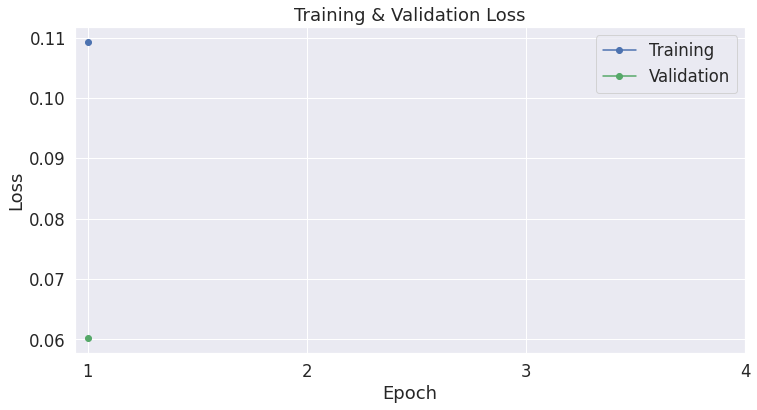

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50260, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

## Saving and Loading Fine-tuned Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 499800K
-rw-r--r-- 1 root root      1K Apr 11 11:44 added_tokens.json
-rw-r--r-- 1 root root      1K Apr 11 11:44 config.json
-rw-r--r-- 1 root root    446K Apr 11 11:44 merges.txt
-rw-r--r-- 1 root root 498455K Apr 11 11:44 pytorch_model.bin
-rw-r--r-- 1 root root      1K Apr 11 11:44 special_tokens_map.json
-rw-r--r-- 1 root root      1K Apr 11 11:44 tokenizer_config.json
-rw-r--r-- 1 root root    878K Apr 11 11:44 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Apr 11 11:44 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ '/content/drive/MyDrive/Zara'

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/Zara/model_save')
tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/Zara/model_save')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

## Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: knit sweater round neckline long sleeve button fastening stripe printSTRIPED KNIT SWEATER


1: midi skirt contrast beltFAUX LEATHER MIDI SKIRT


2: short sleeve t shirt round neckline mickey mouse c disney height model 189 cm 74.4MICKEY MOUSE © DISNEY TOP TRF




In [ ]:
df_validation.reset_index(inplace=True)

In [ ]:
X_valid = df_validation['description_cleaned']
y_valid = df_validation['name']

In [ ]:
X_valid.head()

0    dress round neckline short puff sleeve fasteni...
1                         line skirt elastic waistband
2    slim fit trouser feature pocket double welt po...
3    easy fit car air freshener imagine smell fresh...
4    fit playsuit polyamide blend feature square cu...
Name: description_cleaned, dtype: object

In [ ]:
X_valid.isna().sum()

0

In [ ]:
import string
preds = []
errors = []
error_loc=[]
for i in range(0,len(X_valid)):
  text = X_valid.iloc[i]
  prompt = "<|startoftext|>"+text
  #print(prompt)
  #print(prompt)
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)

  #print(generated)
  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 300,
                                  top_p=0.95, 
                                  num_return_sequences=1
                                  )
  for j, sample_output in enumerate(sample_outputs):
    try:
      s = tokenizer.decode(sample_output, skip_special_tokens=False)
      #s=''.join([c for c in s if c.isupper()])
      #s=s.translate(string.ascii_lowercase)
      #table = str.maketrans('', '', string.ascii_lowercase)
      #preds.append(s.translate(table))
      s = s.split("<|sep|> ")[1]
      s = s.split("<|endoftext|>")[0]
      preds.append(s)
    except:
      print(s)
      error_loc.append(i)
      errors.append(s)

  #print(sample_outputs)
  #
#print(preds)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
X_valid.iloc[[20]].values

array(['dark toned recycled glass candlestick'], dtype=object)

In [ ]:
d='<|startoftext|> black backpack quilt exterior matte finish three zip pocket main compartment inside pocket electronic device laptop 13 inch handle two adjustable padded shoulder strap height length width 43 29 18 cm <|pad|> SPLIT SUIT CLOUD BACKPACK<|endoftext|>'
d.replace('<|pad|>','')


'<|startoftext|> black backpack quilt exterior matte finish three zip pocket main compartment inside pocket electronic device laptop 13 inch handle two adjustable padded shoulder strap height length width 43 29 18 cm  SPLIT SUIT CLOUD BACKPACK<|endoftext|>'

In [ ]:
errors

['<|startoftext|> spray air freshener easily quickly fragrance room floral woody sweet aroma traditional apothecary combine rise collection modern contemporary fragrance vibrant distinct woody note th <|startoftext|> ETERNAL MUSK AIR FRESHENER SPRAY (200 ML)<|endoftext|>',
 '<|startoftext|> feel mule clog slipper decorative gold buckle provide effective foot support well body weight distribution spain <|pad|> COW PRINT COW SOLE MULES<|endoftext|>',
 '<|startoftext|> sunglass resin frame leaf print case include 100 % uv protection category 3 protection s 3 -5 year m 6 10 year l 10 14 year m 10 15 year m 6 10 year l 15 year m 6 9 year inclusive <|pad|> LARGE LEAF SUNGLASSES<|endoftext|>',
 '<|startoftext|> loose fit t shirt round neck contrast long sleeve print piece antoni tapie cadira 1991 c fundacio antoni tapie /vegap 2020 <|pad|> OVERSIZED INTERACTIVE ENTERTAINMENT T-SHIRT<|endoftext|>',
 '<|startoftext|> frame photo size 10x15 cm 13x18 cm feature irregular golden border brush effec

In [ ]:
error_loc

[74, 198, 691, 952, 1435, 1737, 2447, 2792, 3320]

In [ ]:
y_true2 = []
pred2 = []
#tokenizer.tokenize(df_compare.y_true[1])
#df_compare.y_true[1]
for i in df_compare.y_true:
  y_true2.append(np.array(tokenizer.encode(i)))

for i in df_compare.preds:
  pred2.append(np.array(tokenizer.encode(i)))

In [ ]:
X_valid_final = X_valid.drop(error_loc)

In [ ]:
y_valid_final = y_valid.drop(error_loc)

In [ ]:
len(y_valid_final)
#len(preds)+len(errors)

3352

In [ ]:
df_compare = pd.DataFrame()
df_compare['y_true']=y_valid_final
df_compare['preds'] = preds
df_compare['comp']=df_compare['y_true']==df_compare['preds']
df_compare

,y_true,preds,comp
0,SEQUINNED DRESS WITH TIED DETAIL,SEQUINNED DRESS WITH FLORAL PRINT,False
1,KNIT MIDI SKIRT,GINGHAM CHECK SKIRT,False
2,TUXEDO TROUSERS,BASIC TROUSERS,False
3,GREEN HERBS CAR AIR FRESHENER,GREEN HERBS CAR AIR FRESHENER,True
4,ELASTICATED TULLE PLAYSUIT,TULLE DRESS WITH TULLE DETAILS,False
...,...,...,...
3357,GLASSES WITH CLEAR LENSES,LARGE WEDGES WITH CLEAR LENSES,False
3358,TEXTURED PIQUÉ SHIRT,POPLIN SHIRT WITH STAND-UP COLLAR,False
3359,BASIC BOMBER JACKET,FLANNEL BOMBER JACKET,False
3360,COTTON TOWEL WITH LITTLE EARS,SATIN TOWEL WITH LITTLE EARS,False


In [ ]:
leng=[]
for i in range(0,len(y_valid)):
  leng.append(len(y_valid.iloc[i].split()))

In [ ]:
max(leng)

20

In [ ]:
sum(df_compare['comp'])/len(df_compare['comp'])

0.05190930787589499

In [ ]:
df_compare

,y_true,preds,comp
0,SEQUINNED DRESS WITH TIED DETAIL,SEQUINNED DRESS WITH FLORAL PRINT,False
1,KNIT MIDI SKIRT,GINGHAM CHECK SKIRT,False
2,TUXEDO TROUSERS,BASIC TROUSERS,False
3,GREEN HERBS CAR AIR FRESHENER,GREEN HERBS CAR AIR FRESHENER,True
4,ELASTICATED TULLE PLAYSUIT,TULLE DRESS WITH TULLE DETAILS,False
...,...,...,...
3357,GLASSES WITH CLEAR LENSES,LARGE WEDGES WITH CLEAR LENSES,False
3358,TEXTURED PIQUÉ SHIRT,POPLIN SHIRT WITH STAND-UP COLLAR,False
3359,BASIC BOMBER JACKET,FLANNEL BOMBER JACKET,False
3360,COTTON TOWEL WITH LITTLE EARS,SATIN TOWEL WITH LITTLE EARS,False


In [ ]:
text = X_valid_final.iloc[0]
prompt = "<|startoftext|>"+text
#print(prompt)
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

  #print(generated)

sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 300,
                                  top_p=0.95, 
                                  num_return_sequences=1
                                  )
for j, sample_output in enumerate(sample_outputs):
  print(tokenizer.decode(sample_output, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


fade high waist midi skirt patch pocket rear welt pocket metal button fastening height model 177 cm 69.6TECHNICAL SKIRT WITH POCKETS
